July, 2018

**_Author: Dana Chermesh, Regional Planning intern_**

### US Metros comparison
comparison by the county level of 17 regions (CSA's) accross the country

### _Notebook no.4_
# Housing-Jobs balance
### - _Employment data were obtained from: BLS-QCEW_
Data Source: [Bureau of Labor Statistics, Quarterly Census of Employment and Wages](https://www.bls.gov/cew/datatoc.htm) (BLS-QCEW)
### - _Housing data were obtained from PEP/2017/housing_

---- 
# 0 - Imports

In [11]:
import requests
import pandas as pd
import numpy as np

from __future__ import print_function, division
import matplotlib.pylab as pl
# from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set_style('whitegrid')
# import json

# Spatial
import geopandas as gpd
import fiona
import shapely

import statsmodels.formula.api as smf
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


##  Reading in geo-coded dataset
created on a different notebook, please refer to _**0_US_Metro_Comparison_Geographies**_

In [12]:
geo = pd.read_csv('../Regional_USmetros_comparison/data/USmetros_full.csv').iloc[:,:-2] \
            .drop(['Unnamed: 0', 'SHAPE_AREA'], axis=1)
geo['STCO'] = geo['STCO'].apply(lambda x: '{0:0>5}'.format(x))

print(geo.shape)
geo.head()

(270, 4)


,CSA,CSA_name,County_name,STCO
0,488,"San Jose-San Francisco-Oakland, CA",Alameda,06001
1,488,"San Jose-San Francisco-Oakland, CA",Contra Costa,06013
2,488,"San Jose-San Francisco-Oakland, CA",Marin,06041
3,488,"San Jose-San Francisco-Oakland, CA",Napa,06055
4,488,"San Jose-San Francisco-Oakland, CA",San Benito,06069


In [13]:
geo.dtypes

CSA             int64
CSA_name       object
County_name    object
STCO           object
dtype: object

In [14]:
STCO = list(geo['STCO'])

print(type(STCO))
print(len(STCO))
STCO[:10]

<class 'list'>
270


['06001',
 '06013',
 '06041',
 '06055',
 '06069',
 '06075',
 '06077',
 '06081',
 '06085',
 '06087']

# Housing / Jobs Balance analysis

- PEP/2017/housing
- BLS QCEW 2017 annually

# 1. Counties - for mapping

# Total Employement 2000-2017
- 'annual_avg_emplvl'

The data set had been created in notebook **4-EMPLOYMENT_BLS-QCEW10-17** in this repo. 

Employment data were obtained from the _**[Bureau of Labor Statistics, Quarterly Census of Employment and Wages](https://www.bls.gov/cew/datatoc.htm) (BLS-QCEW)**_

In [51]:
JobsCO00_17 = pd.read_csv('exports/Jobs00-17CO.csv').iloc[:,:-2]

JobsCO00_17.rename(columns={'Unnamed: 0':'STCO'}, inplace=True)

JobsCO00_17['STCO'] = JobsCO00_17['STCO'].astype(str)
JobsCO00_17['STCO'] = JobsCO00_17['STCO'].apply(lambda x: '{0:0>5}'.format(x))

JobsCO00_17 = JobsCO00_17.set_index('STCO')

print(JobsCO00_17.shape)
JobsCO00_17.head()

(270, 2)


,Total_emp00,Total_emp17
STCO,,
06001,94458,772071
06013,54606,366799
06041,7975,115421
06055,8109,76765
06069,3002,16977


# 2017

## Total Population from PEP housing 2017
Detailing on Population and Housing Estimates APIs: https://www.census.gov/data/developers/data-sets/popest-popproj/popest.2000-2010_Intercensals.html

- [examples for /data/2017/pep/population](https://api.census.gov/data/2017/pep/population/examples.html)

In [35]:
# POP2017 data for all counties in the US
POP2017 = pd.read_json('https://api.census.gov/data/2017/pep/population?get='+
                         'POP,GEONAME&for=county:*')

POP2017.columns = POP2017.iloc[0]
POP2017 = POP2017[1:]

POP2017['state'] = POP2017['state'].apply(lambda x: '{0:0>2}'.format(x))
POP2017['county'] = POP2017['county'].apply(lambda x: '{0:0>3}'.format(x))
POP2017['STCO'] = POP2017[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

POP2017 = POP2017.drop(['state', 'county'], axis=1)
POP2017.columns = ['TotalPOP17','Name', 'STCO']

print(POP2017.shape)
POP2017.head()

(3220, 3)


,TotalPOP17,Name,STCO
1,55504,"Autauga County, Alabama",01001
2,212628,"Baldwin County, Alabama",01003
3,25270,"Barbour County, Alabama",01005
4,22668,"Bibb County, Alabama",01007
5,58013,"Blount County, Alabama",01009


## Total Housing from PEP housing 2017

- [examples for /data/2017/pep/housing](https://api.census.gov/data/2017/pep/housing/examples.html)

In [36]:
# HU2017 data for all counties in the US
totalHU17 = pd.read_json('https://api.census.gov/data/2017/pep/housing?get='+
                         'HUEST,GEONAME&for=county:*&DATE=10')

totalHU17.columns = totalHU17.iloc[0]
totalHU17 = totalHU17[1:]

totalHU17['state'] = totalHU17['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU17['county'] = totalHU17['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU17['STCO'] = totalHU17[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU17 = totalHU17.drop(['state', 'county','DATE'], axis=1)
totalHU17.columns = ['TotalHousing17','Name', 'STCO']

print(totalHU17.shape)
totalHU17.head()

(3142, 3)


,TotalHousing17,Name,STCO
1,372981,"Fairfield County, Connecticut",09001
2,379719,"Hartford County, Connecticut",09003
3,88285,"Litchfield County, Connecticut",09005
4,76339,"Middlesex County, Connecticut",09007
5,367195,"New Haven County, Connecticut",09009


## Merge Population + Housing year 2017

In [39]:
PEP17 = POP2017.merge(totalHU17, on='STCO')

PEP17 = PEP17.drop(['Name_x'], axis=1)
PEP17.rename(columns={'Name_y':'Name'}, inplace=True)

print(PEP17.shape)
PEP17.head()

(3142, 4)


,TotalPOP17,STCO,TotalHousing17,Name
0,55504,01001,23495,"Autauga County, Alabama"
1,212628,01003,114162,"Baldwin County, Alabama"
2,25270,01005,11970,"Barbour County, Alabama"
3,22668,01007,9187,"Bibb County, Alabama"
4,58013,01009,24314,"Blount County, Alabama"


---- 

# 2010

## Total Housing 2010 PEP 2010 -- Not in use 

This data set is called "int_housingunits 2000" and it includes both 2000 and 2010 Census Decennials data.

- API Call: api.census.gov/data/2000/pep/int_housingunits
- [examples](https://api.census.gov/data/2000/pep/int_housingunits.html)
- [variables](https://api.census.gov/data/2000/pep/int_housingunits/variables.html) in /data/2000/pep/int_housingunits/variables

In [27]:
# HU2010 data for all counties in the US, from PEP housing 2000-2010
totalHU10 = pd.read_json('https://api.census.gov/data/2000/pep/int_housingunits?get='+
                         'HUEST,GEONAME&for=county:*&DATE=10')

totalHU10.columns = totalHU10.iloc[0]
totalHU10 = totalHU10[1:]

totalHU10['state'] = totalHU10['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU10['county'] = totalHU10['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU10['STCO'] = totalHU10[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU10 = totalHU10.drop(['state', 'county', 'DATE'], axis=1)
totalHU10.columns = ['TotalHousing10','Name', 'STCO']

print(totalHU10.shape)
totalHU10.head()

(3143, 3)


,TotalHousing10,Name,STCO
1,358484,"Fairfield County, Connecticut",09001
2,372325,"Hartford County, Connecticut",09003
3,86754,"Litchfield County, Connecticut",09005
4,74172,"Middlesex County, Connecticut",09007
5,359866,"New Haven County, Connecticut",09009


## Total Pop + Total Housing 2010 from US Census Bureau Decennial Census 2010

In [28]:
# total HU for all counties in the US, 2010
totalHU10_sf = pd.read_json('https://api.census.gov/data/2010/sf1?get='+
                            'P0010001,H00010001,NAME&for=county:*')
totalHU10_sf.columns = totalHU10_sf.iloc[0]
totalHU10_sf = totalHU10_sf[1:]

totalHU10_sf['state'] = totalHU10_sf['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU10_sf['county'] = totalHU10_sf['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU10_sf['STCO'] = totalHU10_sf[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU10_sf = totalHU10_sf.drop(['state', 'county'], axis=1)
totalHU10_sf.columns = ['TotalPop10','TotalHousing10','Name', 'STCO']

print(totalHU10_sf.shape)
totalHU10_sf.head()

(3221, 4)


,TotalPop10,TotalHousing10,Name,STCO
1,54571,22135,Autauga County,01001
2,182265,104061,Baldwin County,01003
3,27457,11829,Barbour County,01005
4,22915,8981,Bibb County,01007
5,57322,23887,Blount County,01009


----

# 2000

## Total Pop + Total Housing 2000 from US Census Bureau Decennial Census 2000

In [29]:
# total HU for all counties in the US, 2000
totalHU00 = pd.read_json('https://api.census.gov/data/2000/sf1?get='+
                         'P001001,H001001,NAME&for=county:*')
totalHU00.columns = totalHU00.iloc[0]
totalHU00 = totalHU00[1:]

totalHU00['state'] = totalHU00['state'].apply(lambda x: '{0:0>2}'.format(x))
totalHU00['county'] = totalHU00['county'].apply(lambda x: '{0:0>3}'.format(x))
totalHU00['STCO'] = totalHU00[['state', 'county']].apply(lambda x: ''.join(x), axis=1)

totalHU00 = totalHU00.drop(['state', 'county'], axis=1)
totalHU00.columns = ['TotalPop00','TotalHousing00','Name', 'STCO']

print(totalHU00.shape)
totalHU00.head()

(3141, 4)


,TotalPop00,TotalHousing00,Name,STCO
1,43671,17662,Autauga County,01001
2,140415,74285,Baldwin County,01003
3,29038,12461,Barbour County,01005
4,20826,8345,Bibb County,01007
5,51024,21158,Blount County,01009


----
# Population + Housing + Employment change 00-17

## Merge pop+housing 2000, 2017, then merge with Jobs

In [62]:
# merge pop+hou 2000 with pop+hou 2017
popHou00_17 = totalHU00.merge(PEP17, on='STCO')

popHou00_17 = popHou00_17.drop(['Name_x'], axis=1)
popHou00_17.rename(columns={'Name_y':'Name'}, inplace=True)
popHou00_17 = popHou00_17.set_index(['STCO','Name'])
# make dtypes numeric
popHou00_17 = popHou00_17.apply(pd.to_numeric,
                                errors='coerce').reset_index()

# merge popHou with Jobs00-17
ALL_co00_17 = popHou00_17.merge(JobsCO00_17, left_on='STCO',
                                right_index=True).set_index(['STCO','Name'])

print(ALL_co00_17.shape)
print(ALL_co00_17.dtypes)
ALL_co00_17.head()

(269, 6)
TotalPop00        int64
TotalHousing00    int64
TotalPOP17        int64
TotalHousing17    int64
Total_emp00       int64
Total_emp17       int64
dtype: object


,,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17
STCO,Name,,,,,,
06001,"Alameda County, California",1443741,540183,1663190,606052,94458,772071
06013,"Contra Costa County, California",948816,354577,1147439,414007,54606,366799
06037,"Los Angeles County, California",9519338,3270909,10163507,3542636,134446,4394364
06041,"Marin County, California",247289,104990,260955,113126,7975,115421
06055,"Napa County, California",124279,48554,140973,55847,8109,76765


### Exporting to .csv

In [63]:
ALL_co00_17.to_csv('exports/popHouEmp_co00_17.csv')

## Not exported; for plotting - change claculations

In [64]:
ALL_co00_17['Pop_NET00-17'] = ALL_co00_17['TotalPOP17'] - ALL_co00_17['TotalPop00']
ALL_co00_17['Pop_%00-17'] = (ALL_co00_17['TotalPOP17'] - ALL_co00_17['TotalPop00']) \
                            / ALL_co00_17['TotalPop00']

ALL_co00_17['hu_NET00-17'] = ALL_co00_17['TotalHousing17'] - ALL_co00_17['TotalHousing00']
ALL_co00_17['hu_%00-17'] = (ALL_co00_17['TotalHousing17'] - ALL_co00_17['TotalHousing00']) \
                           / ALL_co00_17['TotalHousing00']

ALL_co00_17['emp_NET00-17'] = ALL_co00_17['Total_emp17'] - ALL_co00_17['Total_emp00']
ALL_co00_17['emp_%00-17'] = (ALL_co00_17['Total_emp17'] - ALL_co00_17['Total_emp00']) \
                           / ALL_co00_17['Total_emp00']

print(ALL_co00_17.shape)
print(ALL_co00_17.dtypes)
ALL_co00_17.head()

(269, 12)
TotalPop00          int64
TotalHousing00      int64
TotalPOP17          int64
TotalHousing17      int64
Total_emp00         int64
Total_emp17         int64
Pop_NET00-17        int64
Pop_%00-17        float64
hu_NET00-17         int64
hu_%00-17         float64
emp_NET00-17        int64
emp_%00-17        float64
dtype: object


,,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17,Pop_NET00-17,Pop_%00-17,hu_NET00-17,hu_%00-17,emp_NET00-17,emp_%00-17
STCO,Name,,,,,,,,,,,,
06001,"Alameda County, California",1443741,540183,1663190,606052,94458,772071,219449,0.152000,65869,0.121938,677613,7.173696
06013,"Contra Costa County, California",948816,354577,1147439,414007,54606,366799,198623,0.209338,59430,0.167608,312193,5.717192
06037,"Los Angeles County, California",9519338,3270909,10163507,3542636,134446,4394364,644169,0.067670,271727,0.083074,4259918,31.684974
06041,"Marin County, California",247289,104990,260955,113126,7975,115421,13666,0.055263,8136,0.077493,107446,13.472853
06055,"Napa County, California",124279,48554,140973,55847,8109,76765,16694,0.134327,7293,0.150204,68656,8.466642


# CSAs aggregation for Pop-Housing-Employment balance

In [66]:
# merging with geo data to get CSA's
ALL_co00_17_1 = ALL_co00_17.iloc[:,:-6].reset_index()

ALL_co00_17_1 = ALL_co00_17_1.merge(geo, on='STCO').set_index('County_name')
ALL_co00_17_1 = ALL_co00_17_1.drop('Name', axis=1)

print(ALL_co00_17_1.shape)
ALL_co00_17_1.head()

(269, 9)


,STCO,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17,CSA,CSA_name
County_name,,,,,,,,,
Alameda,06001,1443741,540183,1663190,606052,94458,772071,488,"San Jose-San Francisco-Oakland, CA"
Contra Costa,06013,948816,354577,1147439,414007,54606,366799,488,"San Jose-San Francisco-Oakland, CA"
Los Angeles,06037,9519338,3270909,10163507,3542636,134446,4394364,348,"Los Angeles-Long Beach, CA"
Marin,06041,247289,104990,260955,113126,7975,115421,488,"San Jose-San Francisco-Oakland, CA"
Napa,06055,124279,48554,140973,55847,8109,76765,488,"San Jose-San Francisco-Oakland, CA"


In [71]:
CSAs_00_17 = ALL_co00_17_1.groupby(['CSA', 'CSA_name']).sum().reset_index()

CSAs_00_17['CSA_short'] = CSAs_00_17['CSA_name'].str.split('-').str[0]
CSAs_00_17['CSA_short'] = CSAs_00_17['CSA_short'].replace(['San Jose'], ['San Francisco']) 
CSAs_00_17 = CSAs_00_17.set_index(['CSA', 'CSA_name', 'CSA_short'])

print(CSAs_00_17.shape)
CSAs_00_17

(15, 6)


,,,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17
CSA,CSA_name,CSA_short,,,,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",Atlanta,4778990,1853158,6555956,2565044,418865,2844759
148,"Boston-Worcester-Providence, MA-RI-NH-CT",Boston,7630016,3135867,8233270,3482074,265445,4120001
176,"Chicago-Naperville, IL-IN-WI",Chicago,4088612,1516964,4690448,1813562,586991,2058285
206,"Dallas-Fort Worth, TX-OK",Dallas,5565005,2180002,7811847,2979956,751903,3584626
216,"Denver-Aurora, CO",Denver,2629980,1068646,3447033,1390357,761298,1692056
220,"Detroit-Warren-Ann Arbor, MI",Detroit,5456428,2208124,5336286,2356800,964603,2312528
288,"Houston-The Woodlands, TX",Houston,4878216,1865805,7093190,2686600,90659,2968025
348,"Los Angeles-Long Beach, CA",Los Angeles,12365627,4240393,13353907,4644752,392822,5989256
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",Miami,5475847,2379888,6828241,2854735,443388,2720504


In [80]:
CSAs_00_17['Pop_NET00-17'] = CSAs_00_17['TotalPOP17'] - CSAs_00_17['TotalPop00']
CSAs_00_17['Pop_%00-17'] = (CSAs_00_17['TotalPOP17'] - CSAs_00_17['TotalPop00']) \
                           / CSAs_00_17['TotalPop00']

CSAs_00_17['hu_NET00-17'] = CSAs_00_17['TotalHousing17'] - CSAs_00_17['TotalHousing00']
CSAs_00_17['hu_%00-17'] = (CSAs_00_17['TotalHousing17'] - CSAs_00_17['TotalHousing00']) \
                           / CSAs_00_17['TotalHousing00']

CSAs_00_17['emp_NET00-17'] = CSAs_00_17['Total_emp17'] - CSAs_00_17['Total_emp00']
CSAs_00_17['emp_%00-17'] = (CSAs_00_17['Total_emp17'] - CSAs_00_17['Total_emp00']) \
                           / CSAs_00_17['Total_emp00']

print(CSAs_00_17.shape)
print(CSAs_00_17.dtypes)
CSAs_00_17

(15, 12)
TotalPop00          int64
TotalHousing00      int64
TotalPOP17          int64
TotalHousing17      int64
Total_emp00         int64
Total_emp17         int64
Pop_NET00-17        int64
Pop_%00-17        float64
hu_NET00-17         int64
hu_%00-17         float64
emp_NET00-17        int64
emp_%00-17        float64
dtype: object


,,,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17,Pop_NET00-17,Pop_%00-17,hu_NET00-17,hu_%00-17,emp_NET00-17,emp_%00-17
CSA,CSA_name,CSA_short,,,,,,,,,,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",Atlanta,4778990,1853158,6555956,2565044,418865,2844759,1776966,0.371829,711886,0.384147,2425894,5.791589
148,"Boston-Worcester-Providence, MA-RI-NH-CT",Boston,7630016,3135867,8233270,3482074,265445,4120001,603254,0.079063,346207,0.110402,3854556,14.521110
176,"Chicago-Naperville, IL-IN-WI",Chicago,4088612,1516964,4690448,1813562,586991,2058285,601836,0.147198,296598,0.195521,1471294,2.506502
206,"Dallas-Fort Worth, TX-OK",Dallas,5565005,2180002,7811847,2979956,751903,3584626,2246842,0.403745,799954,0.366951,2832723,3.767405
216,"Denver-Aurora, CO",Denver,2629980,1068646,3447033,1390357,761298,1692056,817053,0.310669,321711,0.301045,930758,1.222594
220,"Detroit-Warren-Ann Arbor, MI",Detroit,5456428,2208124,5336286,2356800,964603,2312528,-120142,-0.022018,148676,0.067331,1347925,1.397388
288,"Houston-The Woodlands, TX",Houston,4878216,1865805,7093190,2686600,90659,2968025,2214974,0.454054,820795,0.439915,2877366,31.738338
348,"Los Angeles-Long Beach, CA",Los Angeles,12365627,4240393,13353907,4644752,392822,5989256,988280,0.079922,404359,0.095359,5596434,14.246743
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",Miami,5475847,2379888,6828241,2854735,443388,2720504,1352394,0.246974,474847,0.199525,2277116,5.135719


### Exporting to .csv

In [81]:
CSAs_00_17.to_csv('exports/CSA_popHouEmp_00_17_1.csv')

----
# Housing / Jobs Balance: County level for mapping

### Merging with geo

In [79]:
# merging with geo data to get CSA's
ALL_co00_17_2 = ALL_co00_17.iloc[:,:-6].reset_index()

Balance_CO = ALL_co00_17_2.merge(geo, on='STCO').set_index('County_name')
Balance_CO = Balance_CO.drop(['Name', 'TotalPop00', 'TotalPOP17'], axis=1)
Balance_CO = Balance_CO.reset_index().set_index(['STCO', 'County_name'])

print(Balance_CO.shape)
Balance_CO.head()

(269, 9)


,STCO,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17,CSA,CSA_name
County_name,,,,,,,,,
Alameda,06001,1443741,540183,1663190,606052,94458,772071,488,"San Jose-San Francisco-Oakland, CA"
Contra Costa,06013,948816,354577,1147439,414007,54606,366799,488,"San Jose-San Francisco-Oakland, CA"
Los Angeles,06037,9519338,3270909,10163507,3542636,134446,4394364,348,"Los Angeles-Long Beach, CA"
Marin,06041,247289,104990,260955,113126,7975,115421,488,"San Jose-San Francisco-Oakland, CA"
Napa,06055,124279,48554,140973,55847,8109,76765,488,"San Jose-San Francisco-Oakland, CA"


In [74]:
Balance_CO.dtypes

STCO               object
TotalPop00          int64
TotalHousing00      int64
TotalPOP17          int64
TotalHousing17      int64
Total_emp00         int64
Total_emp17         int64
Pop_NET00-17        int64
Pop_%00-17        float64
hu_NET00-17         int64
hu_%00-17         float64
emp_NET00-17        int64
emp_%00-17        float64
CSA                 int64
CSA_name           object
dtype: object

## Calculating Balance for years 2000, 2017

In [89]:
Balance_CO['housing/jobs2017'] = Balance_CO['TotalHousing17'] / Balance_CO['Total_emp17']
Balance_CO['housing/jobs2000'] = Balance_CO['TotalHousing00'] / Balance_CO['Total_emp00']

print(Balance_CO.shape)
Balance_CO.head()

(269, 11)


,STCO,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17,CSA,CSA_name,housing/jobs2017,housing/jobs2000
County_name,,,,,,,,,,,
Alameda,06001,1443741,540183,1663190,606052,94458,772071,488,"San Jose-San Francisco-Oakland, CA",0.784969,5.718764
Contra Costa,06013,948816,354577,1147439,414007,54606,366799,488,"San Jose-San Francisco-Oakland, CA",1.128703,6.493371
Los Angeles,06037,9519338,3270909,10163507,3542636,134446,4394364,348,"Los Angeles-Long Beach, CA",0.806177,24.328794
Marin,06041,247289,104990,260955,113126,7975,115421,488,"San Jose-San Francisco-Oakland, CA",0.980116,13.164890
Napa,06055,124279,48554,140973,55847,8109,76765,488,"San Jose-San Francisco-Oakland, CA",0.727506,5.987668


In [90]:
Balance_CO['fromAve17'] = Balance_CO['housing/jobs2017'] - (Balance_CO['TotalHousing17'].sum() /
                                                            Balance_CO['Total_emp17'].sum())

Balance_CO['fromAve00'] = Balance_CO['housing/jobs2000'] - (Balance_CO['TotalHousing00'].sum() /
                                                            Balance_CO['Total_emp00'].sum())


Balance_CO.tail()

,STCO,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17,CSA,CSA_name,housing/jobs2017,housing/jobs2000,fromAve17,fromAve00
County_name,,,,,,,,,,,,,
Hampshire,54027,20203,11185,23471,14036,633,3737,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",3.755954,17.669826,2.894442,12.956096
Jefferson,54037,42190,17623,56338,23181,7183,15440,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",1.501360,2.453432,0.639848,-2.260298
Kenosha,55059,149577,59989,168521,70574,5821,66392,176,"Chicago-Naperville, IL-IN-WI",1.062990,10.305618,0.201478,5.591888
Pierce,55093,36804,13493,41901,16590,6508,10029,378,"Minneapolis-St. Paul, MN-WI",1.654203,2.073294,0.792691,-2.640435
St. Croix,55109,63155,24265,88703,35823,773,33508,378,"Minneapolis-St. Paul, MN-WI",1.069088,31.390686,0.207576,26.676956


In [91]:
print(Balance_CO['TotalHousing17'].sum() / Balance_CO['Total_emp17'].sum())
print(Balance_CO['TotalHousing00'].sum() / Balance_CO['Total_emp00'].sum())

0.8615120017905975
4.713729831723559


In [107]:
Balance_CO['balance_ch'] = Balance_CO['housing/jobs2017'] - Balance_CO['housing/jobs2000']

Balance_CO.iloc[:,-6:].head()

,CSA_name,housing/jobs2017,housing/jobs2000,fromAve17,fromAve00,balance_ch
County_name,,,,,,
Alameda,"San Jose-San Francisco-Oakland, CA",0.784969,5.718764,-0.076543,1.005034,-4.933795
Contra Costa,"San Jose-San Francisco-Oakland, CA",1.128703,6.493371,0.267191,1.779641,-5.364668
Los Angeles,"Los Angeles-Long Beach, CA",0.806177,24.328794,-0.055335,19.615064,-23.522617
Marin,"San Jose-San Francisco-Oakland, CA",0.980116,13.164890,0.118604,8.451160,-12.184774
Napa,"San Jose-San Francisco-Oakland, CA",0.727506,5.987668,-0.134006,1.273938,-5.260162


------

## Reading in Geopgraphies df
Created through notebook #0: **US_Metro_Comparison_Geographies**

- **_Make sure to import GEOPANDAS_**

In [92]:
GEO = gpd.GeoDataFrame.from_file('exports/USmetros_rawNYC.shp')

GEO['STCO'] = GEO['STCO'].astype(str)
GEO['STCO'] = GEO['STCO'].apply(lambda x: '{0:0>5}'.format(x))

GEO['CSA_short'] = GEO['CSA_name'].str.split('-').str[0]
GEO['CSA_short'] = GEO['CSA_short'].replace(['San Jose'], ['San Francisco']) 

print(type(GEO))
print(GEO.shape)
print(GEO.geometry.name)
GEO.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(274, 7)
geometry


,SHAPE_AREA,STCO,County_nam,CSA,CSA_name,geometry,CSA_short
0,3.124167e+09,06001,Alameda,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13618345.0421 4551161.905000001, -1...",San Francisco
1,3.158013e+09,06013,Contra Costa,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13628818.5334 4574539.895900004, -1...",San Francisco
2,2.298070e+09,06041,Marin,488,"San Jose-San Francisco-Oakland, CA","(POLYGON ((-13694586.3189 4579361.395599999, -...",San Francisco
3,3.344885e+09,06055,Napa,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13652937.1333 4664335.483199999, -1...",San Francisco
4,5.596080e+09,06069,San Benito,488,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13541348.2494 4424341.478500001, -1...",San Francisco


## Merging Housing-Jobs data with .shp

In [118]:
Balance_geo = GEO.merge(Balance_CO, on='STCO')

Balance_geo = Balance_geo.drop(['CSA_y', 'CSA_name_y'], axis=1)
Balance_geo.rename(columns={'CSA_x':'CSA','CSA_name_x':'CSA_name'}, inplace=True)
Balance_geo = Balance_geo.set_index('CSA')

print(type(Balance_geo))
print(Balance_geo.shape)
print(Balance_geo.geometry.name)
Balance_geo.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(268, 17)
geometry


,SHAPE_AREA,STCO,County_nam,CSA_name,geometry,CSA_short,TotalPop00,TotalHousing00,TotalPOP17,TotalHousing17,Total_emp00,Total_emp17,housing/jobs2017,housing/jobs2000,fromAve17,fromAve00,balance_ch
CSA,,,,,,,,,,,,,,,,,
488,3.124167e+09,06001,Alameda,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13618345.0421 4551161.905000001, -1...",San Francisco,1443741,540183,1663190,606052,94458,772071,0.784969,5.718764,-0.076543,1.005034,-4.933795
488,3.158013e+09,06013,Contra Costa,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13628818.5334 4574539.895900004, -1...",San Francisco,948816,354577,1147439,414007,54606,366799,1.128703,6.493371,0.267191,1.779641,-5.364668
488,2.298070e+09,06041,Marin,"San Jose-San Francisco-Oakland, CA","(POLYGON ((-13694586.3189 4579361.395599999, -...",San Francisco,247289,104990,260955,113126,7975,115421,0.980116,13.164890,0.118604,8.451160,-12.184774
488,3.344885e+09,06055,Napa,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13652937.1333 4664335.483199999, -1...",San Francisco,124279,48554,140973,55847,8109,76765,0.727506,5.987668,-0.134006,1.273938,-5.260162
488,5.596080e+09,06069,San Benito,"San Jose-San Francisco-Oakland, CA","POLYGON ((-13541348.2494 4424341.478500001, -1...",San Francisco,53234,16499,60310,18876,3002,16977,1.111857,5.496003,0.250345,0.782273,-4.384145


In [102]:
CSAs = Balance_geo.groupby(['CSA', 'CSA_name']).count().reset_index().set_index('CSA')
CSAs = CSAs.iloc[:,:2]
CSAs.columns = ['CSA_name', 'numberCounties']

CSAs['CSA_short'] = CSAs['CSA_name'].str.split('-').str[0]
CSAs['CSA_short'] = CSAs['CSA_short'].replace(['San Jose'], ['San Francisco']) 

print(list(CSAs.index))
print(CSAs.shape)
CSAs

['122', '148', '176', '206', '216', '220', '288', '348', '370', '378', '408', '428', '488', '500', '548']
(15, 3)


,CSA_name,numberCounties,CSA_short
CSA,,,
122,"Atlanta--Athens-Clarke County--Sandy Springs, GA",39,Atlanta
148,"Boston-Worcester-Providence, MA-RI-NH-CT",19,Boston
176,"Chicago-Naperville, IL-IN-WI",18,Chicago
206,"Dallas-Fort Worth, TX-OK",20,Dallas
216,"Denver-Aurora, CO",11,Denver
220,"Detroit-Warren-Ann Arbor, MI",10,Detroit
288,"Houston-The Woodlands, TX",14,Houston
348,"Los Angeles-Long Beach, CA",2,Los Angeles
370,"Miami-Fort Lauderdale-Port St. Lucie, FL",7,Miami


In [103]:
# for plotting in the order I want to

CSAs_sorted = ['500','216', '220','378','148',
               '488','176',  '122','548','408',
               '348', '206', '288', '428', '370']

## General layout for plotting CSA's by counties

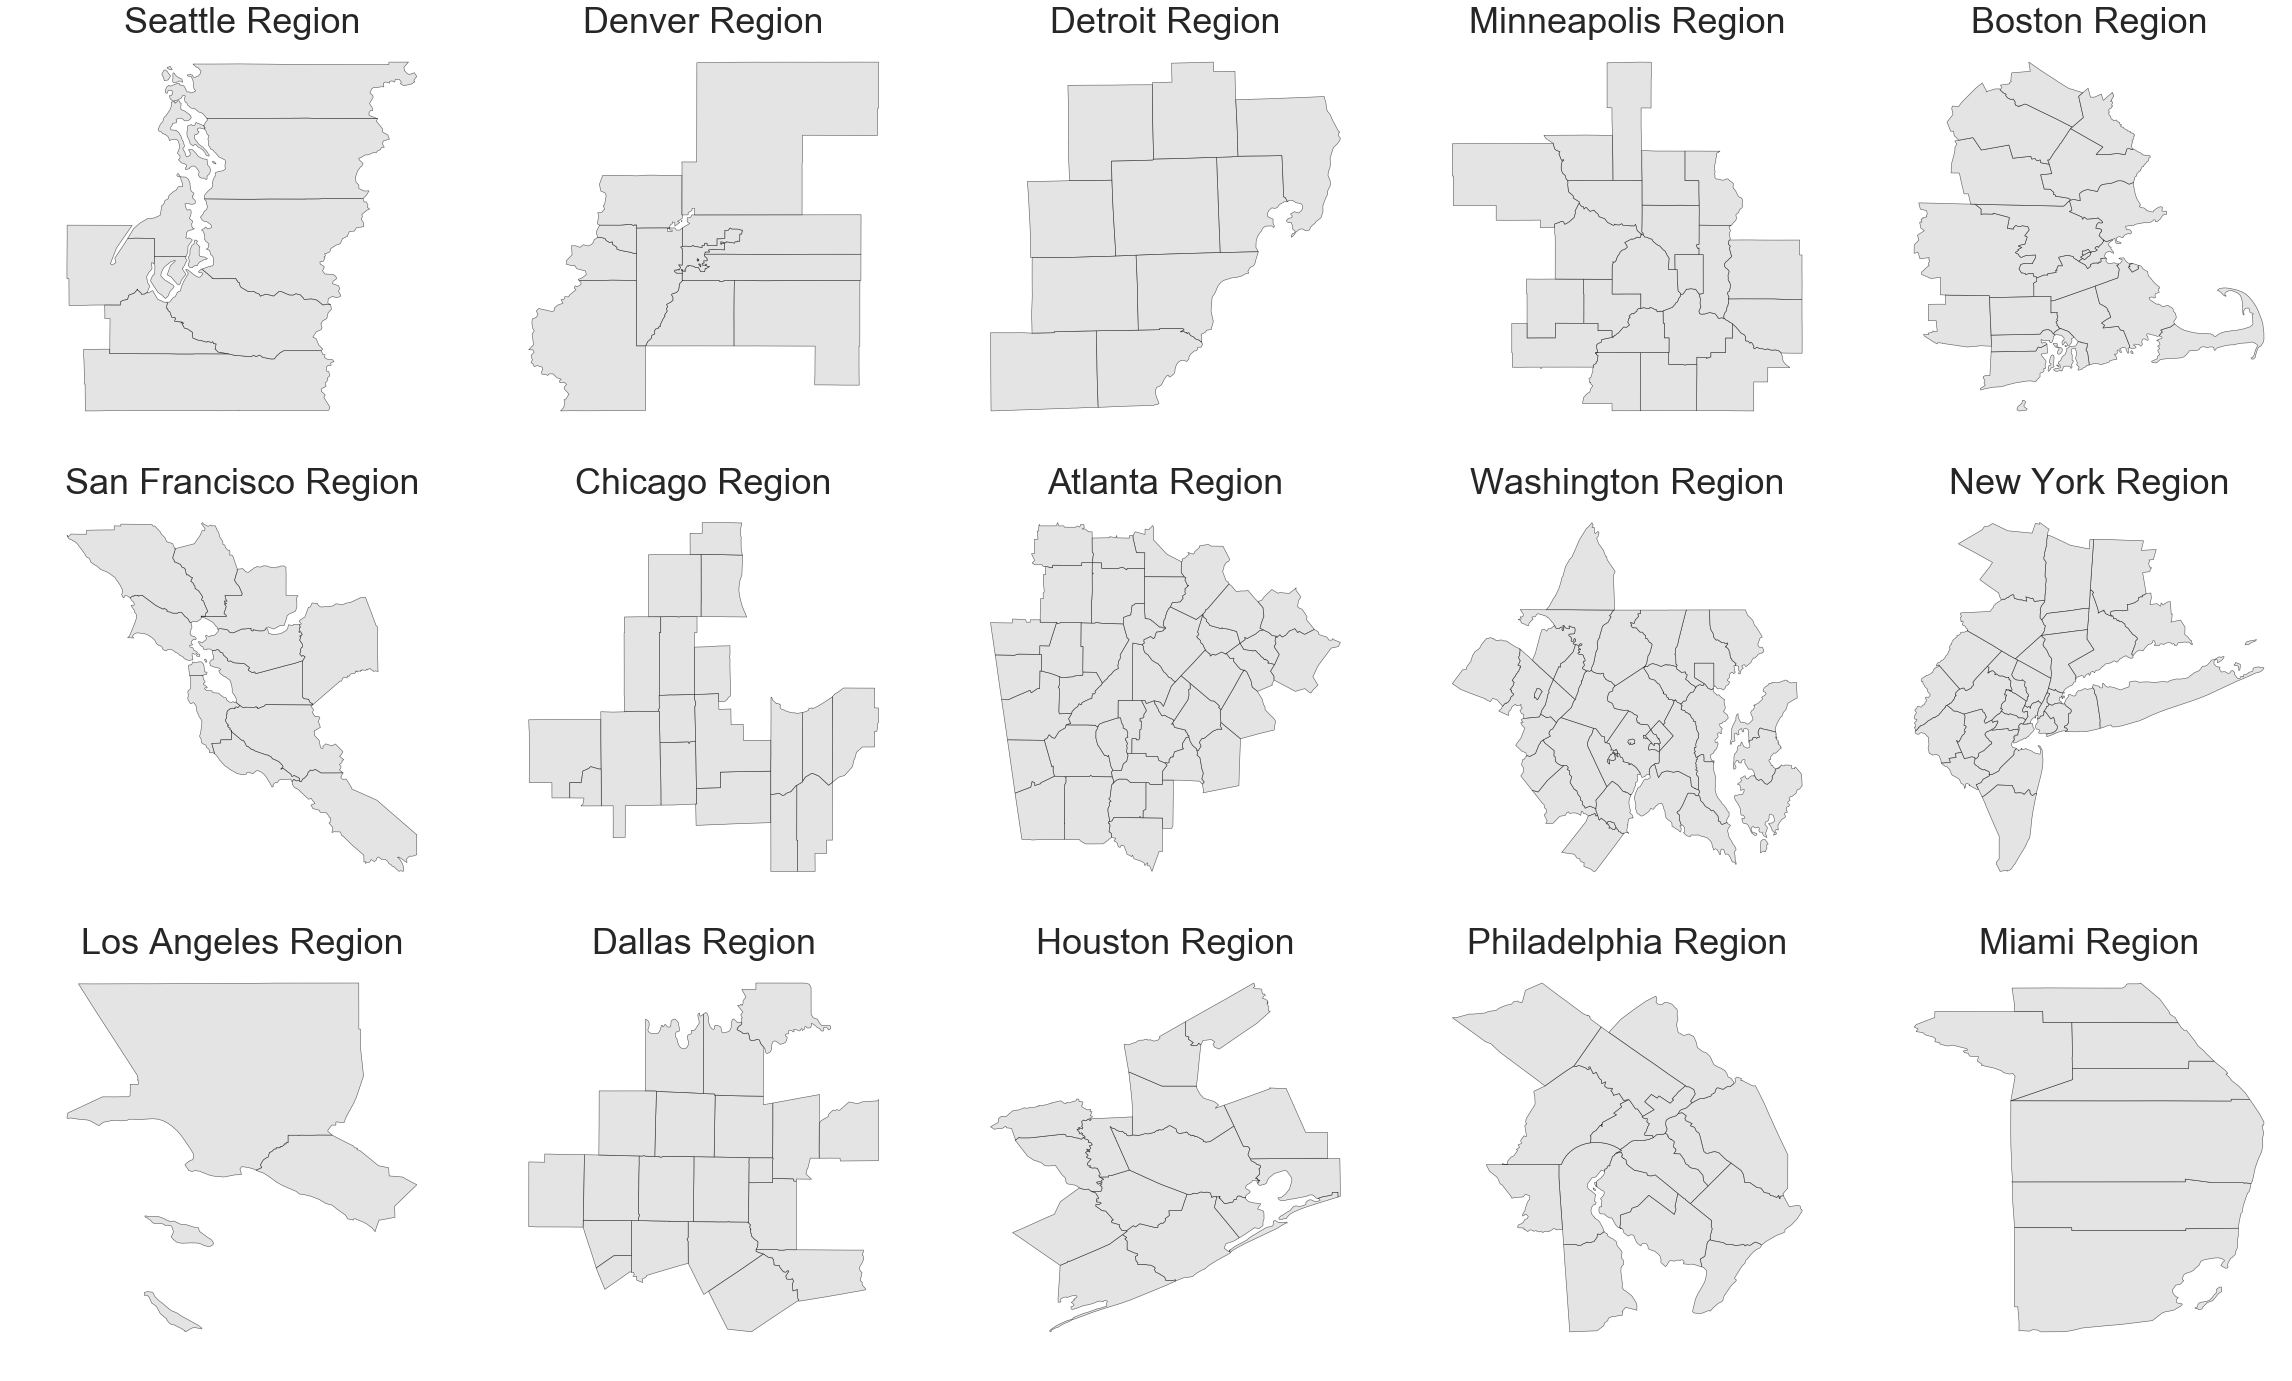

In [106]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")

for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    Balance_geo[Balance_geo.index == CSAs_sorted[k]].plot(ax=ax, edgecolor='k',
                                    color='lightgrey',linewidth=.6, alpha=0.6);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')
    
plt.savefig("exports/CSAsLayout.pdf", transparent=True)

## Plotting Housing-Jobs Balance for all CSA's - county level
- 2010
- 2017
- change 10-17

In [110]:
Balance_geo.iloc[:,-4:-2].describe()[3:]

,housing/jobs2017,housing/jobs2000
min,0.360204,0.480225
25%,0.897968,4.295108
50%,1.094951,11.359730
75%,1.410955,32.554826
max,5.869407,inf


## Balance 2000

/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:956: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


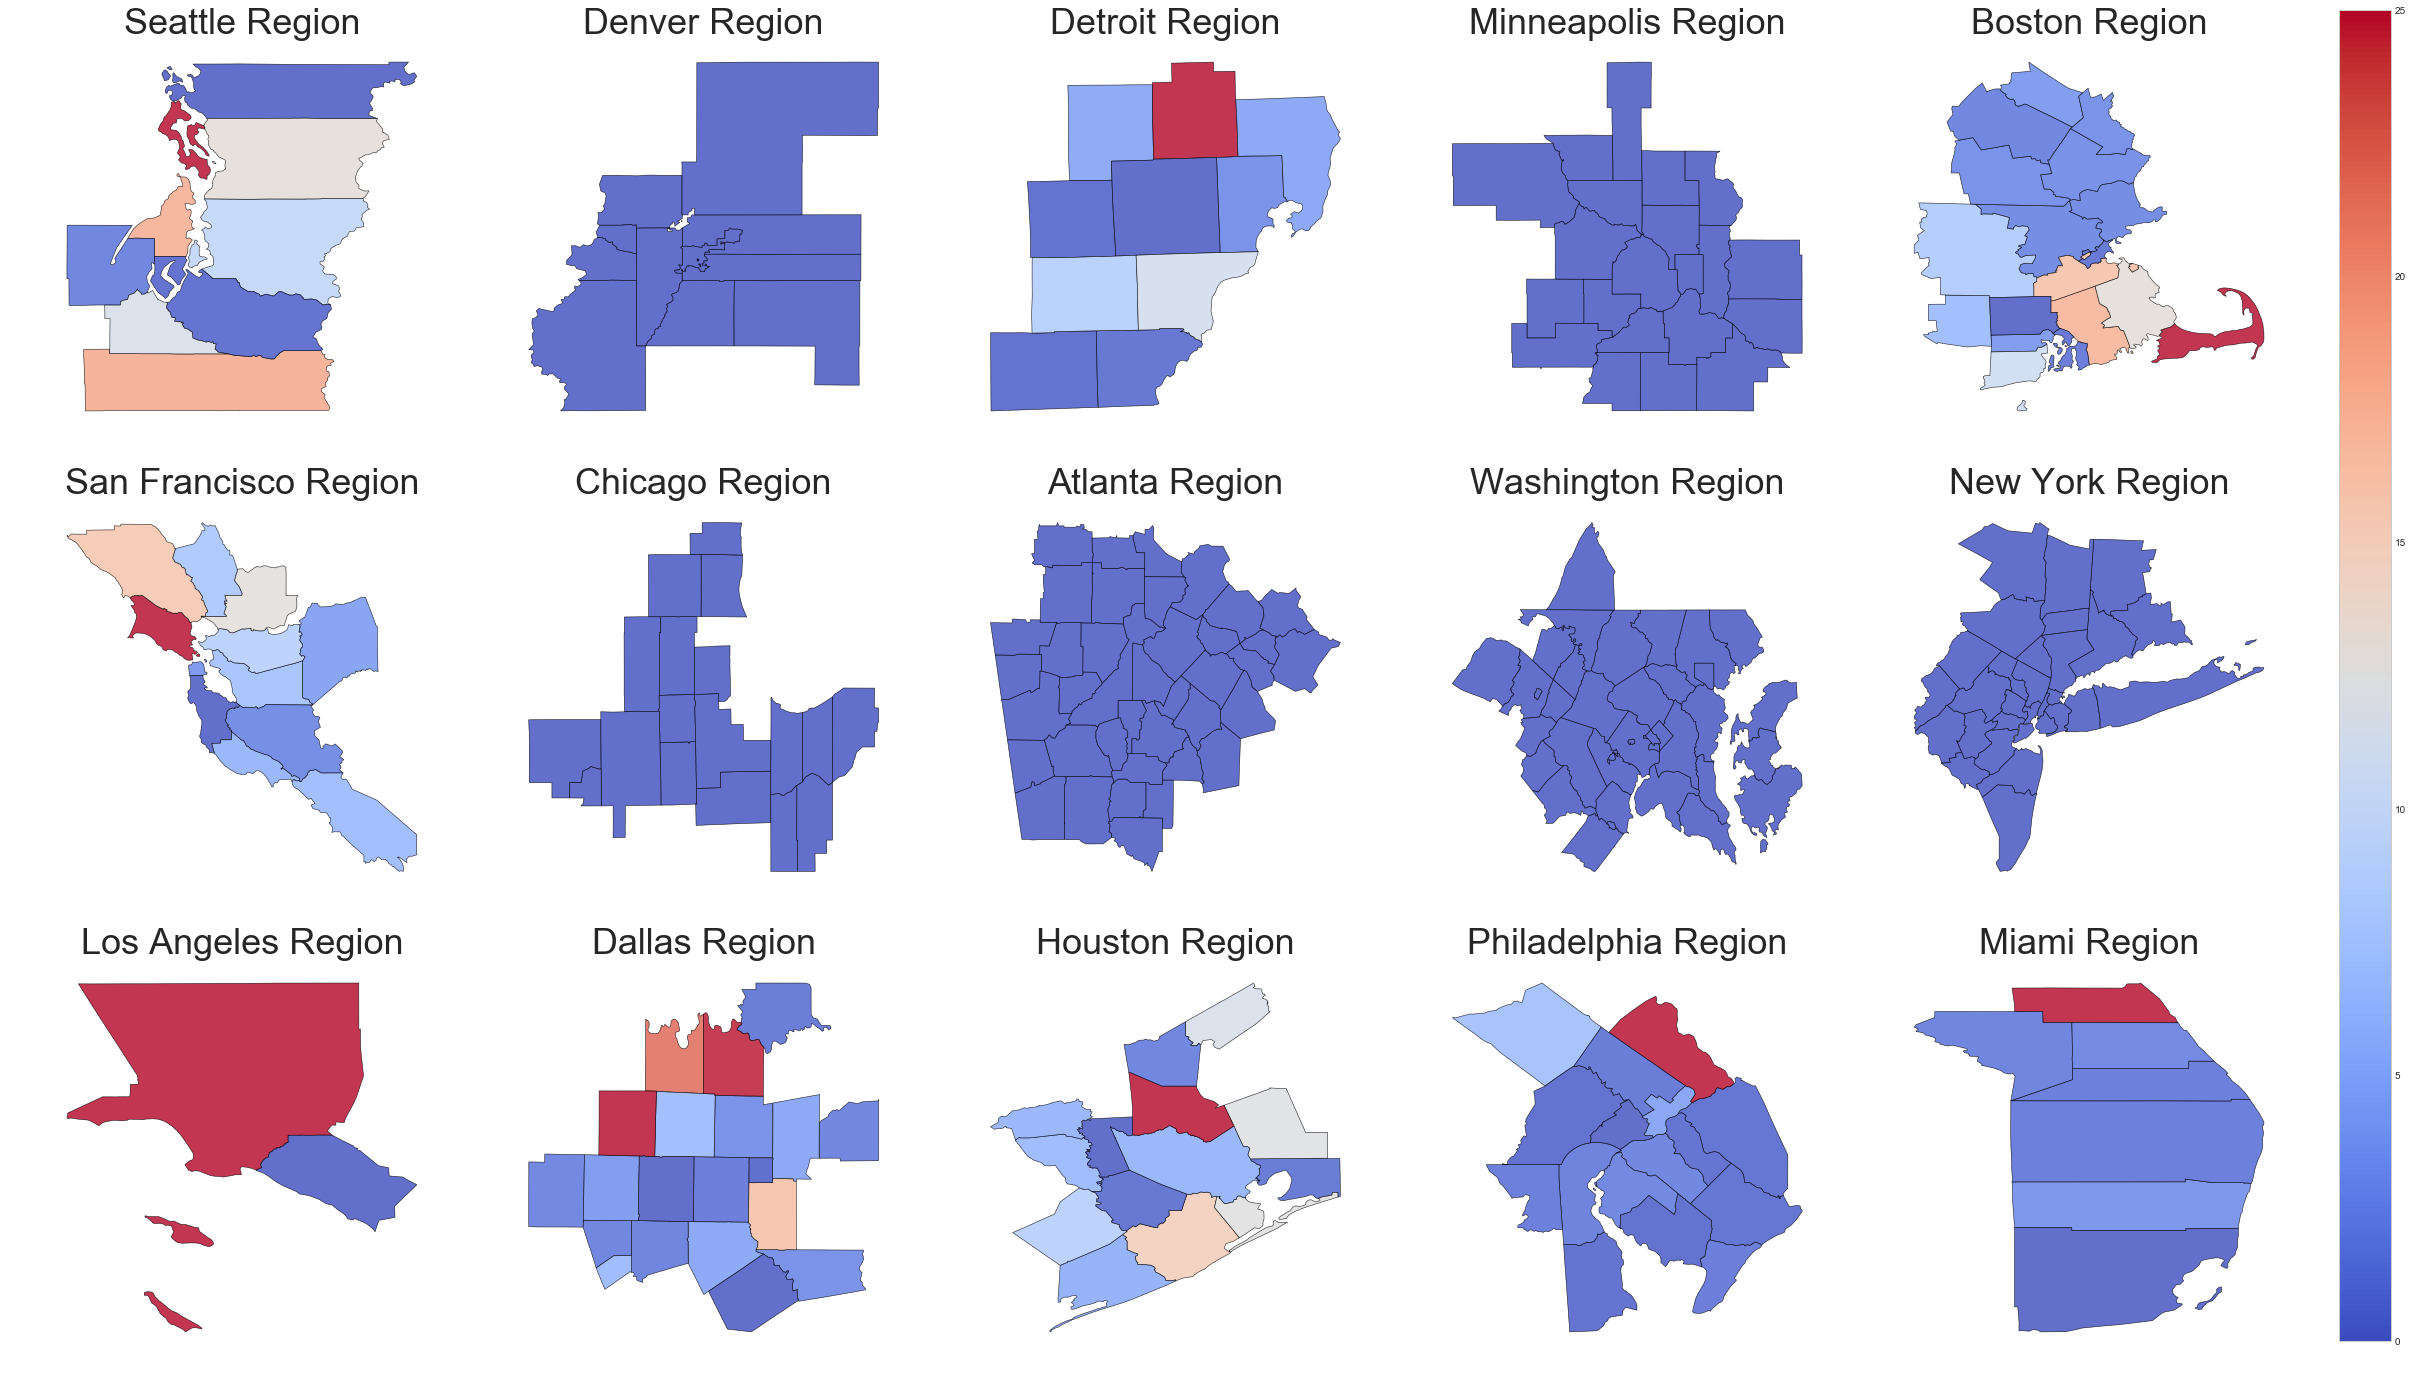

In [117]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = 0, 25

cax = fig.add_axes([0.92, 0.13, 0.018, .77])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical', values=None)


# 8 choroplets of seven major felonies + total
for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    Balance_geo[Balance_geo.index == CSAs_sorted[k]].plot(ax=ax, column='housing/jobs2000',
                                          cmap='coolwarm', edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')
    
plt.savefig("exports/balance00.pdf", transparent=True)

## Balance 2017

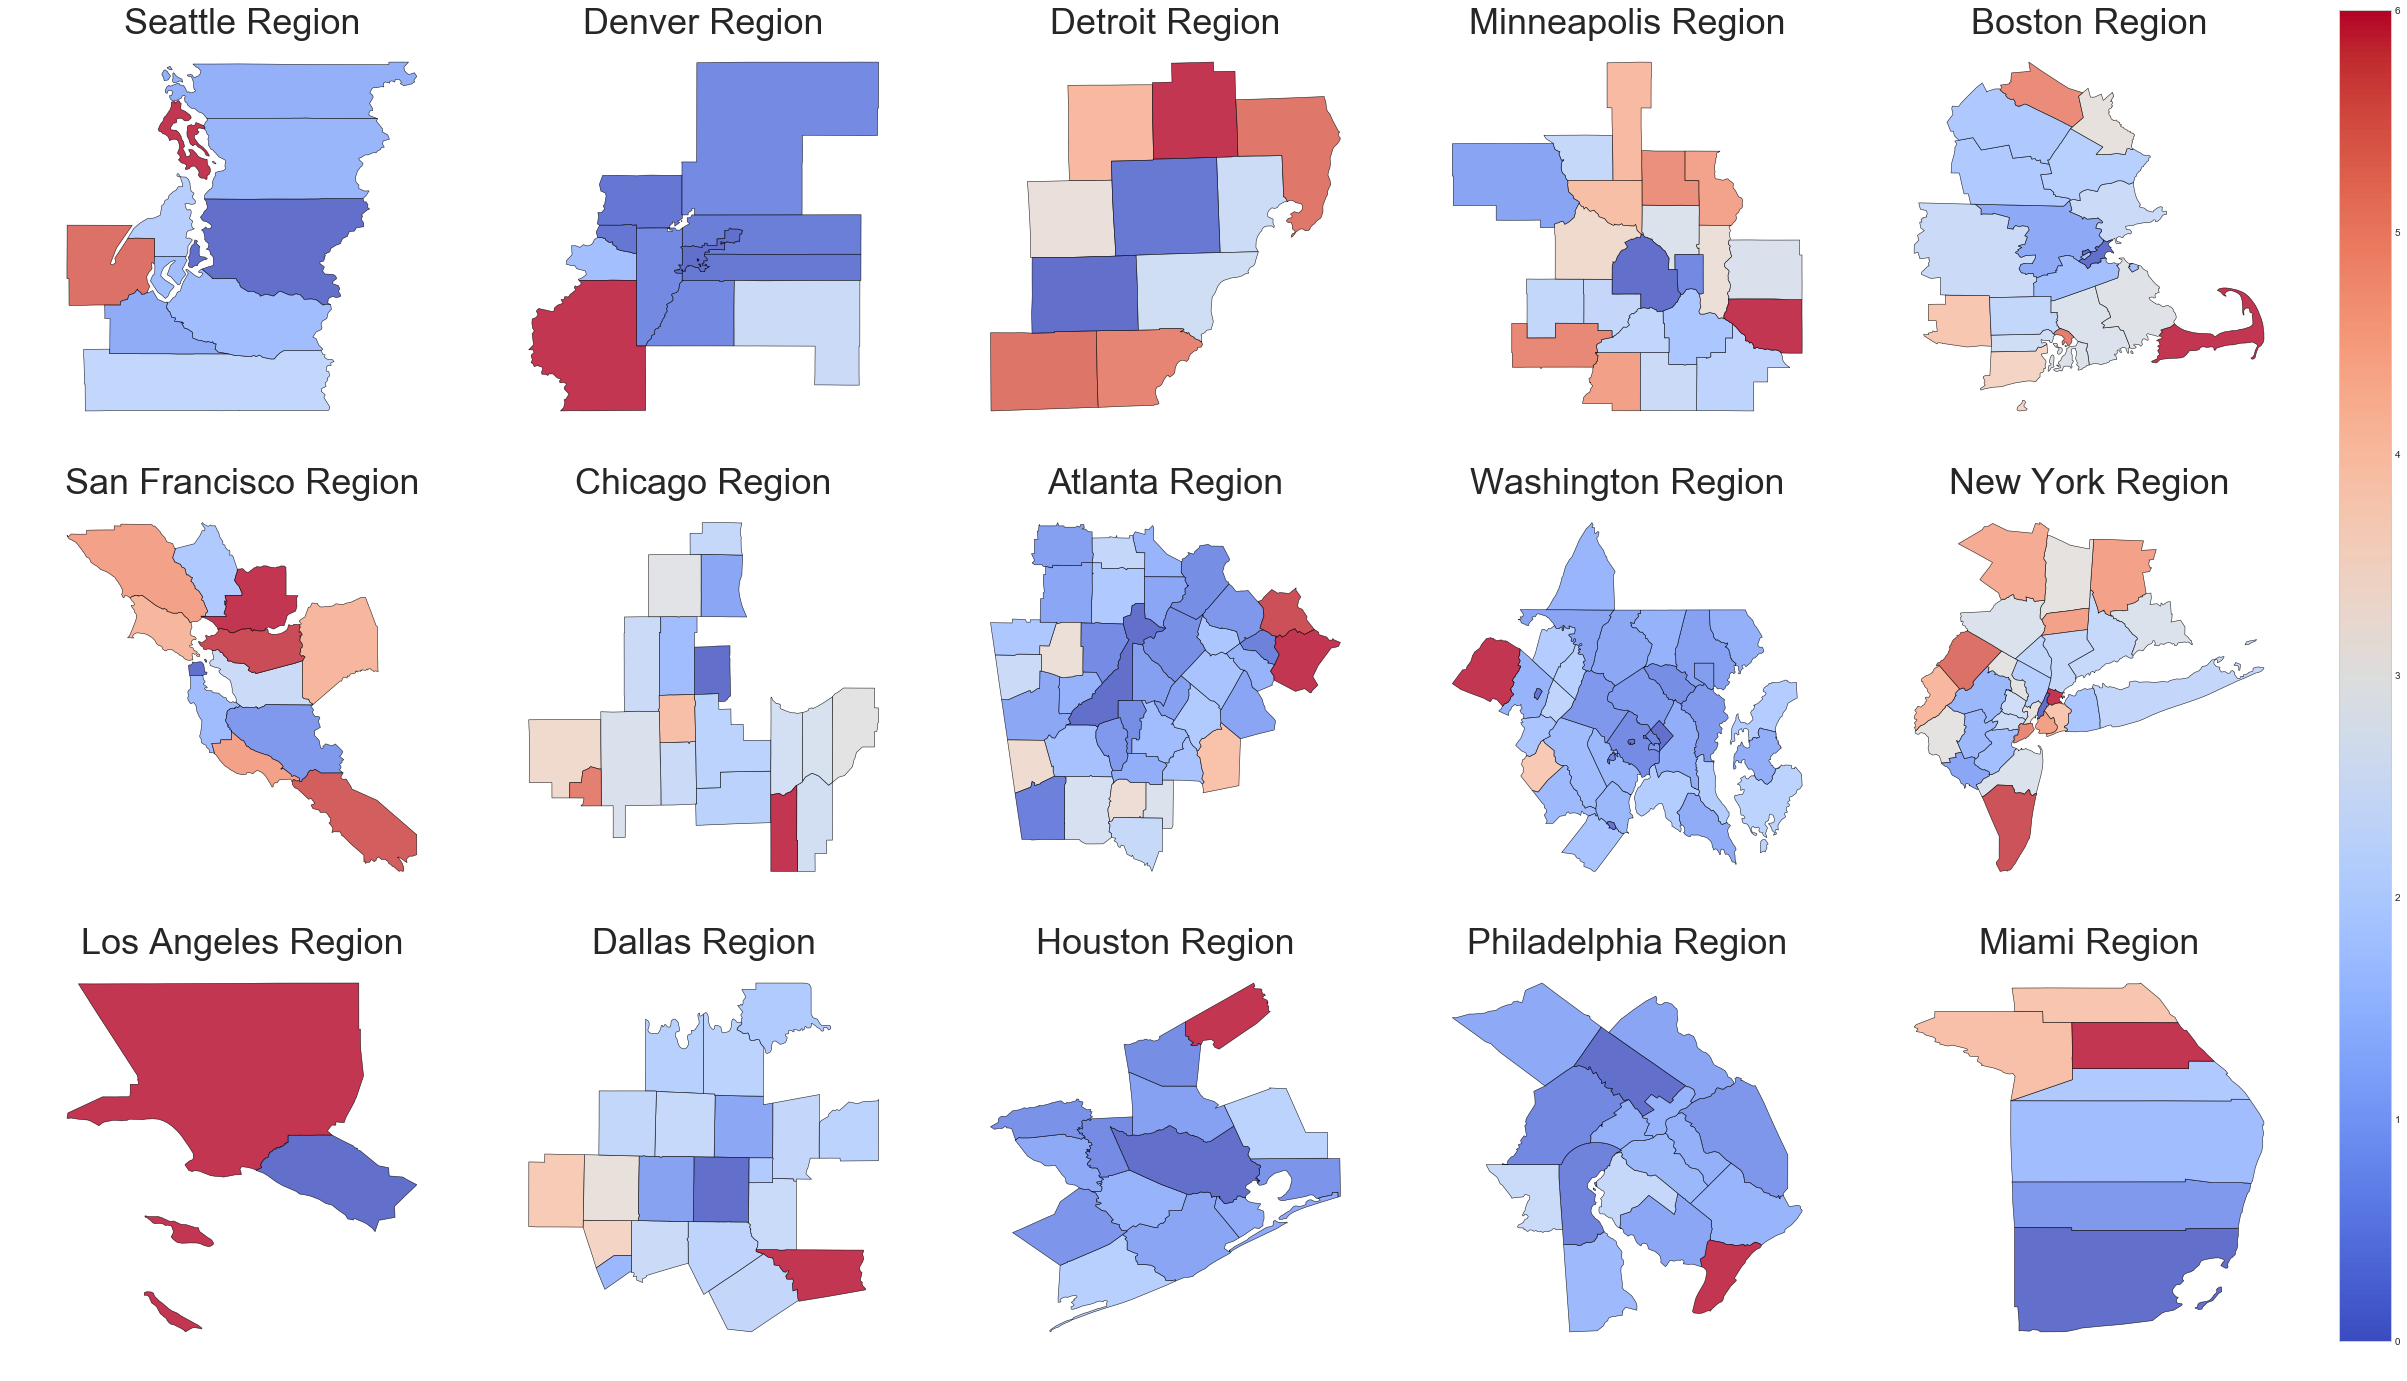

In [116]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = 0, 6

cax = fig.add_axes([0.92, 0.13, 0.018, .77])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical', values=None)


# 8 choroplets of seven major felonies + total
for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    Balance_geo[Balance_geo.index == CSAs_sorted[k]].plot(ax=ax, column='fromAve17',
                                          cmap='coolwarm', edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')
    
plt.savefig("exports/balance17.pdf", transparent=True)

## Balance change 00 vs 17

/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:955: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:956: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


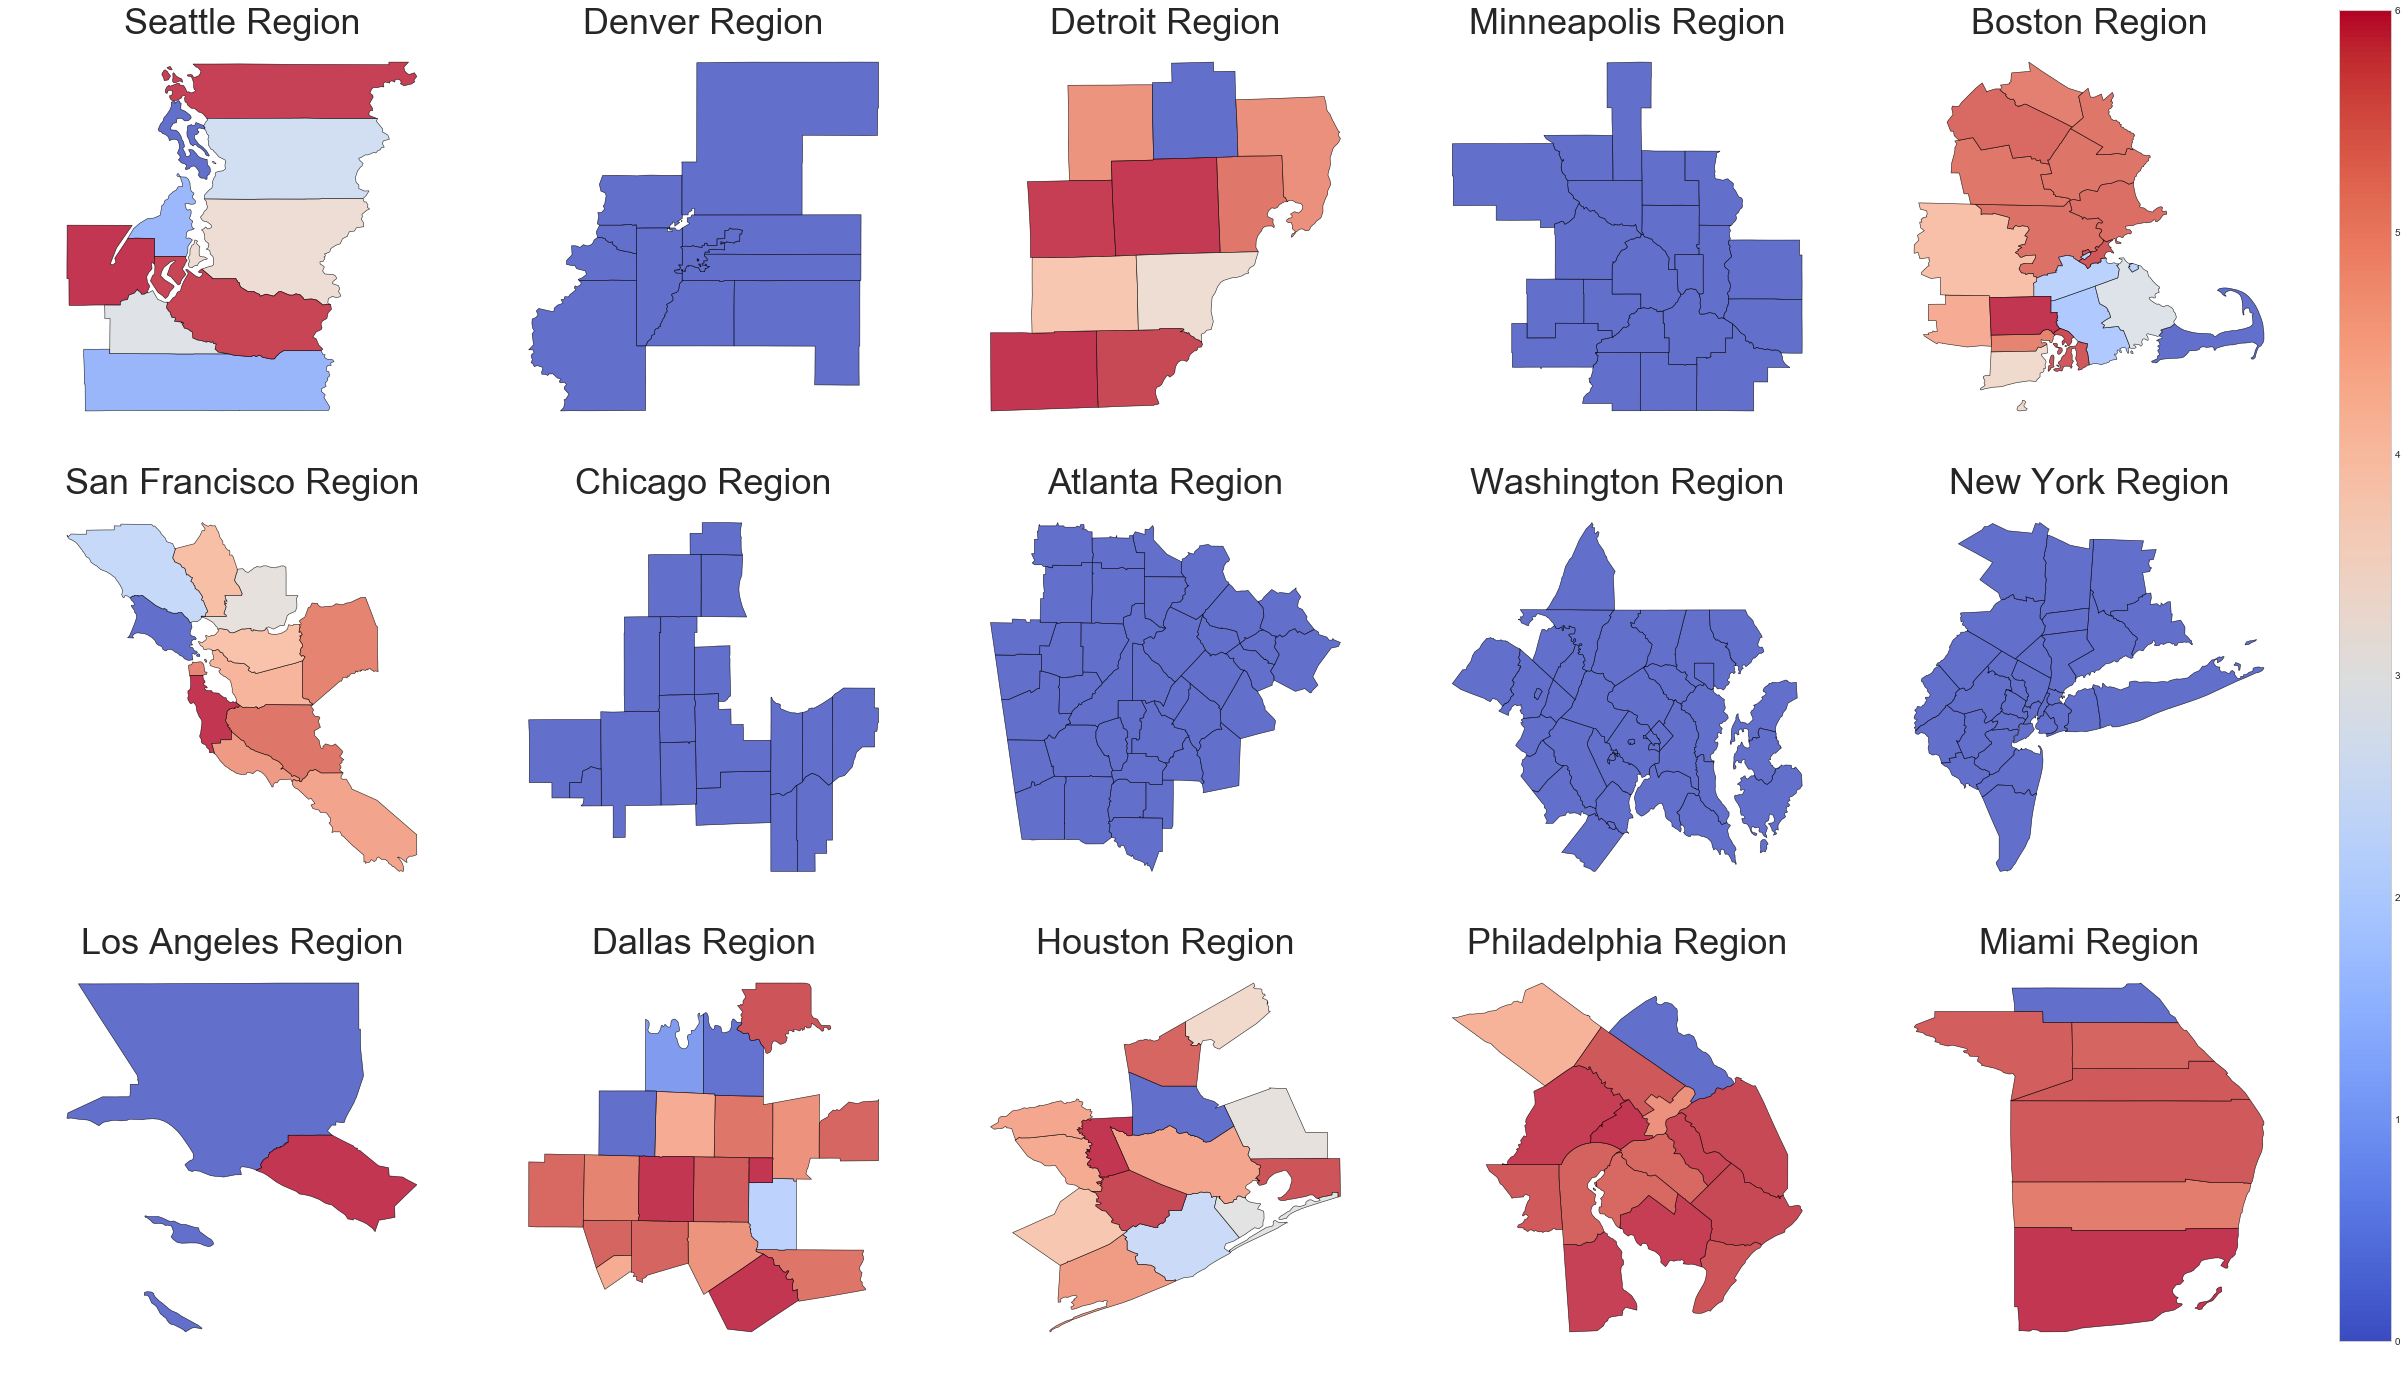

In [119]:
fig = pl.figure(figsize=(40,24))
sns.set_style("whitegrid")
vmin, vmax = 0, 6

cax = fig.add_axes([0.92, 0.13, 0.018, .77])
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax, orientation='vertical', values=None)


# 8 choroplets of seven major felonies + total
for k in range(len(CSAs_sorted)):
    ax = fig.add_subplot(3,5,k+1)
    Balance_geo[Balance_geo.index == CSAs_sorted[k]].plot(ax=ax, column='balance_ch',
                                          cmap='coolwarm', edgecolor='k',linewidth=.6, alpha=0.8);
    ax.set_title('{} Region'.format(CSAs['CSA_short'][CSAs_sorted[k]]), fontsize=36, y=1.015)
    ax.grid(linewidth=0.25)
    ax.axis('off')
    
plt.savefig("exports/balance_ch00-17.pdf", transparent=True)

------

## CSA's

In [47]:
HouJobs = pd.read_excel('BPS_HousingPermits_analysis.xlsx', 
                        sheet_name='HousingJobs_Balance')[:-2].set_index('Name')

HouJobs['housing / jobs 2010'] = HouJobs['housing / jobs 2010'].round(decimals=2)
HouJobs['housing / jobs 2016'] = HouJobs['housing / jobs 2016'].round(decimals=2)
HouJobs['housing / jobs 10-16 NET'] = HouJobs['housing / jobs 10-16 NET'].round(decimals=2)

HouJobs['CSA'] = HouJobs['CSA'].astype(int)

print(HouJobs .shape)
HouJobs 

(15, 5)


,CSA,FullName,housing / jobs 2010,housing / jobs 2016,housing / jobs 10-16 NET
Name,,,,,
New York,408,"New York-Newark, NY-NJ-CT-PA",0.92,0.84,-0.07
Los Angeles,348,"Los Angeles-Long Beach, CA",0.68,0.60,-0.08
Chicago,176,"Chicago-Naperville, IL-IN-WI",0.42,0.39,-0.03
Washington,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",0.84,0.80,-0.04
San Francisco,488,"San Jose-San Francisco-Oakland, CA",0.92,0.77,-0.14
Boston,148,"Boston-Worcester-Providence, MA-RI-NH-CT",0.92,0.84,-0.08
Dallas,206,"Dallas-Fort Worth, TX-OK",0.92,0.81,-0.11
Philadelphia,428,"Philadelphia-Reading-Camden, PA-NJ-DE-MD",0.97,0.93,-0.04
Houston,288,"Houston-The Woodlands, TX",0.94,0.86,-0.08


----
# Census tracts
## Downloaded + cleaned data for years 2000-2017 
_Downloaded and munged by Dara Goldberg_


In [4]:
AlltractsGeo = pd.read_excel("data/ALL Tract Geo Codes.xlsx")
print(AlltractsGeo.shape)
AlltractsGeo.head()

(28066, 5)


,TRACT,CSA,STCO,ST,CO
0,10001041600,428,10001,10,1
1,10003001300,428,10003,10,3
2,10003011100,428,10003,10,3
3,10003011600,428,10003,10,3
4,10003013200,428,10003,10,3


# 2 - Data cleaning and munging

## Total by Industry by Regions
## Total by Industry by Regions - City to region ratio / comparison
## Change by Industry by Regions 
## Change by Industry by Regions - City to region ratio / comparison
## Wages + change by Region (city/region)